# Анализ поведения пользователей в мобильном приложении "Ненужные вещи"

## Введение <a id='1'></a>

**Цель исследования:**

Предоставить product-менеджеру анализ поведения пользователей на основе выделения основных сценариев использования приложения с целью дальнейшей сегментации пользователей. Дальнейшая работа заказчика будет заключаться в проверке гипотез для увеличения вовлеченности пользователей, улучшения функционала приложения и повышения конверсии в целевое действие - *просмотр контактов*.

**Данные:**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.
В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в `/datasets/mobile_sources.csv`:
- *userId* — идентификатор пользователя,
- *source* — источник, с которого пользователь установил приложение.

Колонки в `/datasets/mobile_dataset.csv`:
- *event.time* — время совершения,
- *user.id* — идентификатор пользователя,
- *event.name* — действие пользователя.

Виды действий:
- *advert_open* — открыл карточки объявления,
- *photos_show* — просмотрел фотографий в объявлении,
- *tips_show* — увидел рекомендованные объявления,
- *tips_click* — кликнул по рекомендованному объявлению,
- *contacts_show* и *show_contacts* — посмотрел номер телефона,
- *contacts_call* — позвонил по номеру из объявления,
- *map* — открыл карту объявлений,
- *search_1 — search_7* — разные действия, связанные с поиском по сайту,
- *favorites_add* — добавил объявление в избранное.

**Для выполнения проекта будут проведены следующие этапы работы:**

1. [Введение в проект](#1)
2. [Загрузка данных](#2)
3. [Предобработка данных](#3)
    - проверка на корректность наименований колонок
    - преобразование типов данных
    - проверка на дубликаты
    - проверка на пропуски в данных    
4. [Исследовательский анализ данных](#4)
    - профили пользователей
    - анализ популярности источников установки приложения
    - соотношение пользователей хоть раз выполнявших целевое действие к тем, кто его ни разу не выполнял
    - связь источников установки и выполнения целевого действия
    - пользовательские сессии
    - конверсия пользователей с разбивкой по выполнению целевого действия
    - удержание пользователей с разбивкой по выполнению целевого действия
5. [Основные вопросы исследования](#5)
    - анализ связи целевого события — просмотра контактов — и других действий пользователей:    
        - отбор сценариев, которые приводят к просмотру контактов
        - воронки по основным сценариям в разрезе уникальных пользователей                
    - оценка действий пользователей, выполняющий целевое действие:
        - относительная частота событий в разрезе двух групп пользователей: смотревших и несмотревших контакты `contacts_show`
    - проверка гипотез:
        - конверсия в просмотры контактов различается у групп пользователей, совершивших действия `tips_show` и `tips_click` , и совершивших только `tips_show`
        - конверсия в просмотры контактов одинакова у пользователей, совершивших действия `photos_show` и `favorites_add` и у пользователей совершивших только `photos_show`
6. [Общий вывод и рекомендации по результатам исследования](#6)   

## Загрузка данных<a id='2'></a>

In [7]:
# импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
from plotly import graph_objects as go
import math as mth
import scipy.stats as st
import warnings
warnings.simplefilter("ignore")

Запишем данные о пользователях и источниках установки приложения в датафрейм `dt_sources`, а данные с действиями пользователей в датафрейм `dt_events` и подготовим их к анализу:

In [9]:
dt_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
dt_events = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [10]:
# создадим функцию для первичной обработки данных (вывод общей информации)

def research(data):
    display(data.head(10))                                       # вывод первых строк датафрейма
    print('*' * 50)                                              # разделитель
    data.info()                                                  # вывод общей информации о датафрейме
    print('*' * 50, '\n\033[1m Количество полных дублей: \033[0m', 
            data.duplicated().sum())                             # проверка на полные дубликаты
    print('*' * 50)
    display(data.describe())                                     # описание распределения численных значений
    print('*' * 50)
    
    for x in data.columns:
        display(data[x].value_counts().to_frame())               # распределение значений в каждом столбце

Обратимся к функции и изучим общую информацию о датафреймах:

In [12]:
research(dt_sources)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
************************************************** 
 Количество полных дублей:  0
**************************************************


,userId,source
count,4293,4293
unique,4293,3
top,020292ab-89bc-4156-9acf-68bc2783f894,yandex
freq,1,1934


**************************************************


,count
userId,
020292ab-89bc-4156-9acf-68bc2783f894,1
269e6d1d-5300-4966-8289-77274c30bd9c,1
9b4a420e-70f3-4330-a753-bd7d09d5eb5f,1
b378870a-606b-4b7b-a98e-29becfe330ea,1
ca8b6f37-479a-4943-9670-e5357cc406c8,1
...,...
e5f5b486-b655-40e8-9b3a-ead066e829b6,1
7281558e-9f74-48d5-bc28-b2d0ed80ae8e,1
e8b97fc1-b65d-4c2d-bed0-46910bc2ca8e,1


,count
source,
yandex,1934
other,1230
google,1129


В датафрейме с источником установки приложений пользователями нет полных дубликатов и пропусков. Наиболее популярным источником привлечения пользователей является `yandex`.

In [14]:
research(dt_events)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
************************************************** 
 Количество полных дублей:  0
**************************************************


,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-07 00:00:00.431357,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


**************************************************


,count
event.time,
2019-10-07 00:00:00.431357,1
2019-10-26 11:50:24.060074,1
2019-10-26 12:04:05.811590,1
2019-10-26 12:03:25.793526,1
2019-10-26 12:03:12.294597,1
...,...
2019-10-17 09:55:09.185712,1
2019-10-17 09:55:06.121108,1
2019-10-17 09:55:03.447186,1


,count
event.name,
tips_show,40055
photos_show,10012
advert_open,6164
contacts_show,4450
map,3881
search_1,3506
favorites_add,1417
search_5,1049
tips_click,814


,count
user.id,
cb36854f-570a-41f4-baa8-36680b396370,478
e13f9f32-7ae3-4204-8d60-898db040bcfc,465
9ce63488-758a-481a-bcb5-a02b467e1d84,407
21230dd9-2f7f-4b77-a436-43d4d10388e0,400
be1449f6-ca45-4f94-93a7-ea4b079b8f0f,397
...,...
a328c7d1-ff5b-41df-822a-bccb105fb408,1
6a2e7783-a775-4c7d-adf0-22d1983ce9bd,1
8bc67b38-7e6d-4084-b354-58b30d8f1e6d,1


В датафрейме `dt_events` так же нет полных дубликатов и пропусков. Наиболее популярным действием пользователей является `tips_show` - просмотр рекомендованных объявлений.

**Вывод**

- данные записаны в 2 датафрейма: `dt_sources` - данные о пользователях и источниках установки приложения, `dt_events` - данные о действиях пользователей;
- все данные представлены типом `object`, столбец `event.time` необходимо перевести в формат *datetime*;
- в датафреймах нет полных дубликатов и пропусков;
- в названиях столбцов необходимо поправить стиль с учётом "змеиного регистра".

## Предобработка данных<a id='3'></a>

### Приведение наименования столбцов к корректному стилю 

В датафрейме `dt_sources` необходимо изменить наименования столбца `userId`:

In [20]:
dt_sources = dt_sources.rename(columns={'userId':'user_id'})
dt_sources.columns # проверка

Index(['user_id', 'source'], dtype='object')

В датафрейме `dt_events` необходимо заменить все точки в наименовании столбцов на нижнее подчеркивание:

In [22]:
dt_events.columns = [x.replace('.', '_') for x in dt_events.columns]
dt_events.columns # проверка

Index(['event_time', 'event_name', 'user_id'], dtype='object')

### Преобразование типов данных

Преобразуем столбец `event_time` датафрейма `dt_events` в формат datetime:

In [25]:
dt_events['event_time'] = pd.to_datetime(dt_events['event_time'])
dt_events.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Также можно преобразовать столбец `source` датафрейма `dt_sources` в категориальный тип данных для сокращения использования памяти, так как он содержит небольшое количество уникальных значений:

In [27]:
dt_sources['source'] = dt_sources['source'].astype('category')
dt_sources.info() # проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  4293 non-null   object  
 1   source   4293 non-null   category
dtypes: category(1), object(1)
memory usage: 38.0+ KB


### Проверка на дубликаты

Помимо проверки на полные дубликаты, можно сделать проверку на дубликаты по столбцам `event_time` и `user_id` датафрейма `dt_events`:

In [30]:
dt_events[dt_events[['event_time', 'user_id']].duplicated()].count()

event_time    0
event_name    0
user_id       0
dtype: int64

Дубликатов нет.

**Вывод**

Была выполнена предобработка данных:

- названия столбцов изменены в соответствии с змеиным регистром;
- преобразован тип данных в столбцах `event_time` и `source`;
- в датафреймах нет полных дубликатов и пропусков.

## Исследовательский анализ данных<a id='4'></a>

### Профили пользователей

Объединим датафреймы с источниками установки приложения и событиями пользователей:

In [36]:
# объединение датафремов по столбцу user_id

dt_merged = dt_events.merge(dt_sources, on='user_id')

Добавим в таблицу столбец `target_action` с булевым признаком, который будет равен `True` для пользователей, которые хоть раз просмотривали контакты:

In [38]:
user_contacts = (
    dt_merged.loc[(dt_merged['event_name']=='contacts_show')|(dt_merged['event_name']=='show_contacts')]['user_id']
    .unique()
)
dt_merged['target_action'] = dt_merged['user_id'].isin(user_contacts)

In [39]:
# находим профили пользователей

profiles = (
        dt_merged.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg(
            {
                'source':'first',
                'event_time':'first'
            }
        )
        .rename(columns={'event_time': 'first_ts'})
        .reset_index()
    )

In [40]:
# добавляем в профили признак: просматривал ли пользователь контакты хоть раз

profiles['target_action'] = profiles['user_id'].isin(dt_merged.query('target_action == True')['user_id'].unique())

In [41]:
# добавляем столбец с date (без времени)

profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.date

# вывод первых строк датафрейма

profiles.head()

,user_id,source,first_ts,target_action,dt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989359,False,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,2019-10-19 21:34:33.849769,True,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,yandex,2019-11-01 13:54:35.385028,False,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,google,2019-10-18 22:14:05.555052,False,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,yandex,2019-10-25 16:44:41.263364,True,2019-10-25


Найдём минимальную и максимальную дату регистрации пользователей в имеющихся данных:

In [43]:
display(profiles['dt'].min())
profiles['dt'].max()

datetime.date(2019, 10, 7)

datetime.date(2019, 11, 3)

Таким образом, представлены данные за 4 недели.

### Источники установки приложения

Ниже проверим сколько пользователей устанавливали приложении из разных источников:

In [47]:
df = profiles.groupby('source')['user_id'].count().sort_values(ascending=False).reset_index()
df.columns = ['source', 'count']
df

,source,count
0,yandex,1934
1,other,1230
2,google,1129


Построим круговую диаграмму для визуализации доли каждого источника:

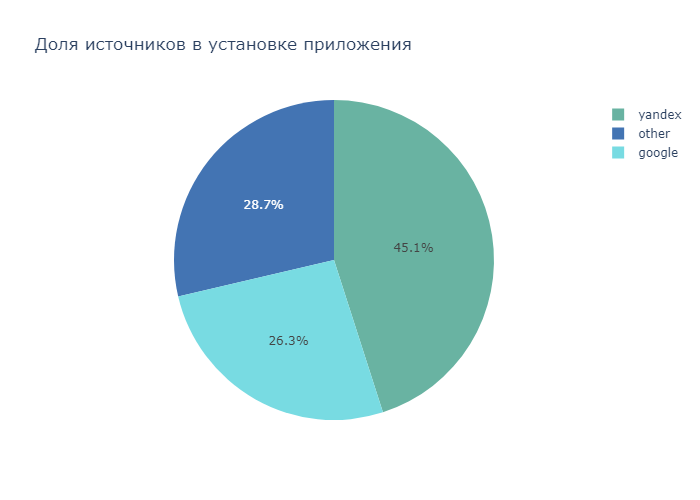

In [49]:
fig = px.pie(df,
             values='count',
             names='source',
             title='Доля источников в установке приложения',
             color_discrete_sequence = ["#69b3a2", "#4374B3", "#78DBE2"])
fig.show("png")

Таким образом, чаще всего приложение устанавливают через `yandex` - в 45% случаев, реже всего - через `google` - в 26% случаев.

### Соотношение пользователей выполнявших и не выполнявших целевое действие

Для того, чтобы рассмотреть соотношение пользователей выполнявших и не выполнявших целевое действие выведем значения суммарного количества каждого вида пользователей, а затем построим круговую диаграмму с соотношением:

In [53]:
df = profiles.groupby('target_action')['user_id'].nunique().sort_values(ascending=False).reset_index()
df.columns = ['target_action', 'count']
df

,target_action,count
0,False,3312
1,True,981


Строим круговую диаграмму:

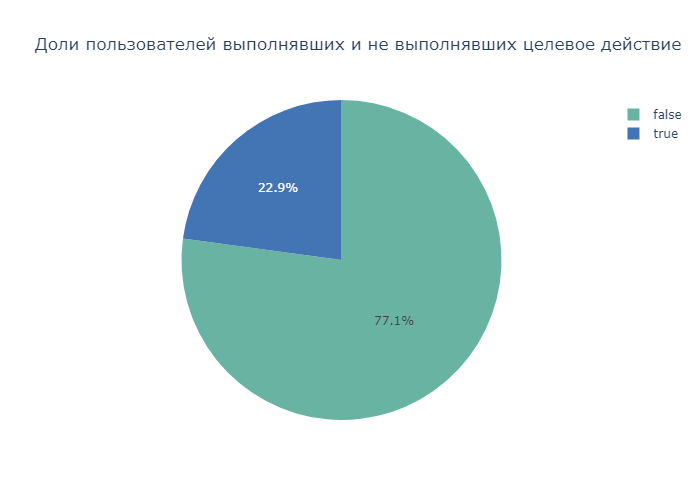

In [55]:
fig = px.pie(df,
             values='count',
             names='target_action',
             title='Доли пользователей выполнявших и не выполнявших целевое действие',
             color_discrete_sequence = ["#69b3a2", "#4374B3"])
fig.show("png")

Таким образом, общая конверсия в целевое действие около 23%. Большинство пользователей ни разу не просматривали контакты покупателей. Скорее всего, они не находят в приложении того, что искали, либо осуществляют только продажу товаров и их не интересует покупка.

### Источники установки приложения и просмотр контактов

Для того, чтобы определить пользователи, пришедшие из каких источников чаще просматривают контакты, используем объединенные таблицы `dt_sources` и `dt_events`.

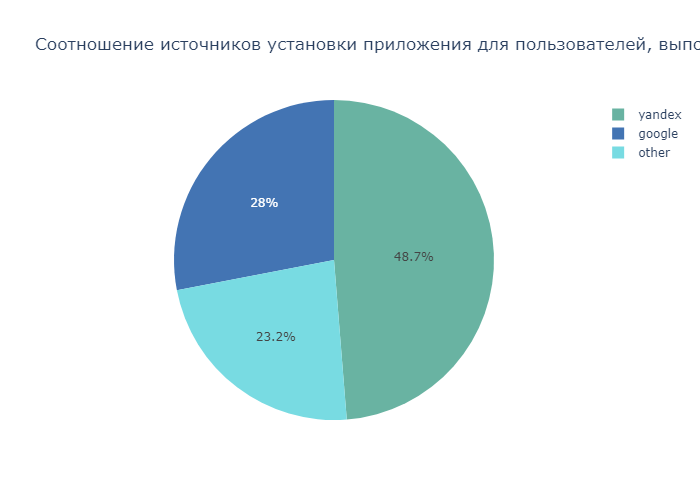

In [59]:
df = (
    dt_merged.query('event_name == "contacts_show" | event_name == "show_contacts"')[['user_id', 'source']]
    .drop_duplicates()       # удаляем дубликаты, чтобы оставить только уникальных пользователей
    .reset_index(drop=True)
)

# строим круговую диаграмму

fig = px.pie(df.groupby('source')['user_id'].count().reset_index(),
             values='user_id',
             names='source',
             title='Соотношение источников установки приложения для пользователей, выполняющих целевое действие',
             color_discrete_sequence = ["#69b3a2", "#4374B3", "#78DBE2"])
fig.show("png")

Просматривающие контакты пользователи в большинстве пришли в приложении из `yandex`, реже - из `google`. Доли приблизительно равны общим долям пользователей по скачиванию приложения, значит, скорее всего, зависимости между источниками установки и выполнением целевого действия нет.

### Выделение пользовательских сессий

Для выделения пользовательских сессий, нужно выбрать тайм-аут.

Добавим в таблицу с действиями пользователей столбец с датой действия (без времени), затем рассчитаем разницу во времени между действиями пользователя, сгруппировав данные по пользователю и дате:

In [63]:
dt_merged['dt'] = pd.to_datetime(dt_merged['event_time']).dt.date # добавляем дату
dt_merged = dt_merged.sort_values(['user_id', 'event_time']) # сортируем датафрейм
dt_merged['time_diff'] = dt_merged.groupby(['user_id', 'dt'])['event_time'].diff() # находим разницу во времени
dt_merged['time_diff'] = [round(x.total_seconds()/60, 1) for x in dt_merged['time_diff']] # отображаем разницу в минутах

Теперь у нас есть столбец со временем в минутах между действиями пользователя за каждый активный день:

In [65]:
dt_merged.head(10)

,event_time,event_name,user_id,source,target_action,dt,time_diff
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,NaN
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.8
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.6
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.3
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.2
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.2
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.8
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,1.0
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-09,NaN


Чтобы отобрать время тайм-аута, найдём 95-ый, 97-ой и 99-ый процентили по столбцу `time_diff`:

In [67]:
dt_merged['time_diff'].quantile([.95, .97, .99])

0.95     18.800
0.97     51.800
0.99    247.721
Name: time_diff, dtype: float64

В 97% случаев между действиями пользователя в рамках одного календарного дня проходит менее 51,8 минуты. Округлим значение до целого и будем считать тайм-аутом для сессии пользователя 52 минуты.

In [69]:
quantile97 = round(dt_merged['time_diff'].quantile( .97),0)

Выделим пользовательские сессии:

In [71]:
# определяем тайм-аут сессии 52 минуты и присваем каждой номер
g = (dt_merged.groupby('user_id')['event_time'].diff() > pd.Timedelta(minutes=quantile97)).cumsum()
# создаем счётчик сессий
dt_merged['session_id'] = dt_merged.groupby(['user_id', g]).ngroup() + 1
dt_merged.head(15)

,event_time,event_name,user_id,source,target_action,dt,time_diff,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,NaN,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.8,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.6,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.3,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.2,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.2,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,0.8,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,1.0,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-07,2.1,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,False,2019-10-09,NaN,2


### Конверсия пользователей с разбивкой по выполнению целевого действия

#### Функция для расчёта конверсии пользователей

Создадим функцию `get_conversion` для расчёта конверсии пользователей:

In [75]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первого совершения целевого действия для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .reset_index()
    )

    # добавляем данные о совершении целевого действия в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_time']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждого совершения целевого действия
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для сглаживания данных

Создадим функцию `filter_data` для сглаживания данных:

In [78]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации конверсии пользователей

Создадим функцию `plot_conversion` для визуализации конверсии:

In [81]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend().set_visible(False)
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.tight_layout()
    plt.show()
    

#### Расчёт и визуализация конверсии пользователей по выполнению целевого события

Зададим момент анализа и его горизонт:

In [84]:
observation_date = datetime(2019, 11, 4).date()  # момент анализа
horizon_days = 14 # горизонт анализа

Посчитаем конверсию без дополнительных разбивок и построим графики конверсии и динамики конверсии:

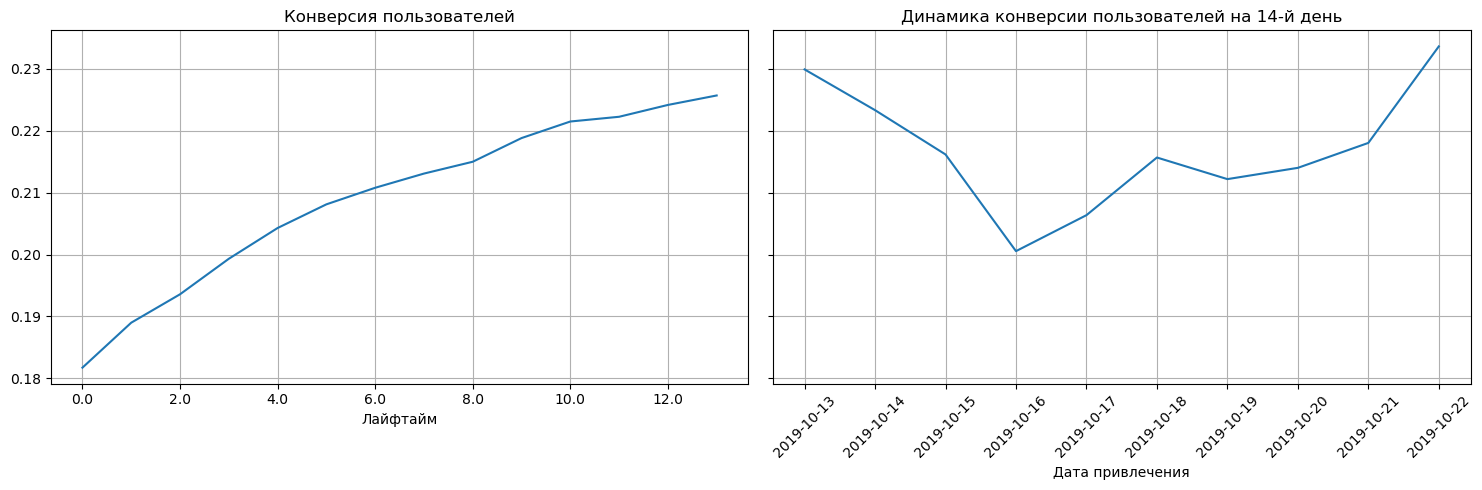

In [86]:
# считаем конверсию без доп разбивки

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, 
    dt_merged.query('event_name == "contacts_show" | event_name == "show_contacts"'),
    observation_date,
    horizon_days)


# строим графики

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Общая конверсия показывает, что в целом пользователи приложения на 14-й день конвертируются с показателем ~ 22,5%. Конверсия 14-го дня волатильная, это может быть связано с небольшим количеством наблюдений, которые сильно влияют на результат.

### Удержание пользователей с разбивкой по выполнению целевого действия

Создадим датафейм `session` с указанием id пользователя, номером сессии и датой начала сессии:

In [90]:
sessions = (
    dt_merged.groupby(['user_id','session_id'])['event_time']
    .first()
    .reset_index()
    .rename(columns={'event_time':'session_start'})
)

#### Функция для расчёта удержания пользователей

Создадим функцию `get_retention` для расчёта коэффициентов удержания пользователей:

In [93]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец target_action в передаваемый dimensions список
    dimensions = ['target_action'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для визуализации удержания пользователей

Создадим функцию `plot_retention` для визуализации удержания:

In [96]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только target_action,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'target_action'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания пользователей хоть раз выполнявших целевое действие
    ax1 = plt.subplot(2, 2, 1)
    retention.query('target_action == True').droplevel('target_action').T.plot(
        grid=True, ax=ax1
    )
    plt.legend().set_visible(False)
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей хоть раз выполнявших целевое действие')

    # во второй ячейке строим кривые удержания пользователей ни разу не выполнявших целевое действие
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('target_action == False').droplevel('target_action').T.plot(
        grid=True, ax=ax2
    )
    plt.legend().set_visible(False)
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей ни разу не выполнявших целевое действие')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'target_action']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('target_action == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.legend().set_visible(False)
    plt.xticks(rotation=45)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей выполнявших цел действие на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('target_action == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей не выполнявших цел действие на {}-й день'.format(
            horizon
        )
    )
    plt.legend().set_visible(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show() 

#### Расчёт и визуализация удержания пользователей по выполнению целевого события

Посчитаем удержание без дополнительных разбивок и построим графики удержания и динамики удержания:

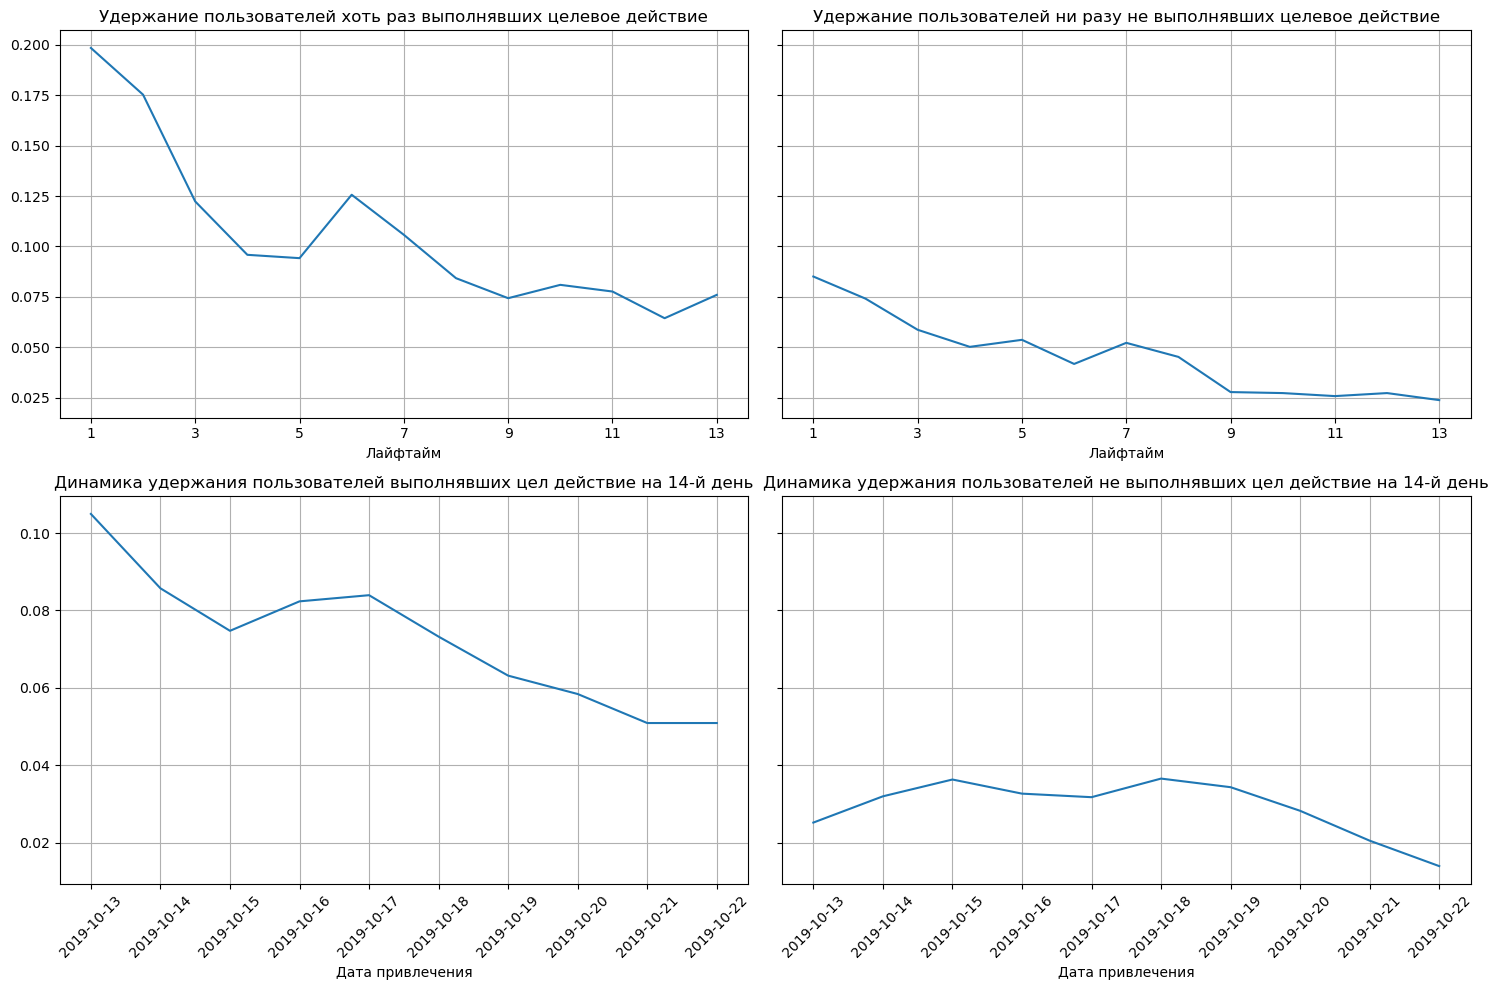

In [99]:
# считаем удержание без доп разбивки

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days)

# строим графики

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей, просматривающих контакты выше, чем непросматривавших. У обеих групп пользователей удержание постепенно снижается, однако есть резкий скачок на 7 день среди пользователей, выполняющих целевое действие - на это может влиять необходимость обновления объявления через неделю после размещения, что может привлекать пользователей для повторного возвращения в приложение и просмотра интересных объявлений. При этом динамика удержания пользователей на 14-й день падает в отношении пользователей привлеченных с конца октября.

## Основные вопросы исследования<a id='5'></a>

### Анализ связи целевого события и других действий пользователей

#### Построение диаграммы Санкея

Для нахождения сценариев с целевым событием построим Диаграмму Санкея, демонстрирующую потоки от одного целевого действия пользователя к другому.

Построение такой визуализации требует отфильтровать только те сессии, в которых есть действие "просмотр контактов". Также для построения сценариев предлагается объединить действия `contacts_show` и `show_contacts` и все значения поиска по сайту `search_1-search_7` к одному виду - `search`.

In [105]:
dt_merged['event_name'] = dt_merged['event_name'].replace({'show_contacts':'contacts_show'})
dt_merged['event_name'] = dt_merged['event_name'].replace(to_replace=r'^search_.$', value='search', regex=True)

In [106]:
# проверка
dt_merged['event_name'].unique()

array(['tips_show', 'map', 'search', 'photos_show', 'favorites_add',
       'contacts_show', 'contacts_call', 'advert_open', 'tips_click'],
      dtype=object)

In [107]:
# фильтруем только те сессии, в которых есть просмотр контактов
patterns = dt_merged.query('event_name == "contacts_show"')['session_id'].unique()

Оставляем в датафрейме информацию только о подходящих нам сессиях, добавляем шаги и целевые узлы событий:

In [109]:
# удаляем повторяющиеся события в рамках сессии
filtered_df = dt_merged.drop_duplicates(subset=['event_name', 'session_id']).reset_index(drop=True)
# фильтруем сессии с целевым действием
filtered_df = filtered_df[filtered_df['session_id'].isin(patterns)]
# сортируем по id сессии и времени
filtered_df = filtered_df.sort_values(by=['session_id', 'event_time'])
# добавляем шаги событий
filtered_df['step'] = filtered_df.groupby('session_id').cumcount() + 1    
# добавляем целевые узлы
filtered_df['target'] = filtered_df.groupby('session_id')['event_name'].shift(-1)

In [110]:
filtered_df.head(10) # проверка

,event_time,event_name,user_id,source,target_action,dt,time_diff,session_id,step,target
9,2019-10-20 18:49:24.115634,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-20,NaN,6,1,photos_show
10,2019-10-20 18:59:22.541082,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-20,10.0,6,2,favorites_add
11,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-20,3.7,6,3,contacts_show
12,2019-10-20 19:17:18.659799,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-20,5.5,6,4,contacts_call
13,2019-10-20 19:17:24.887762,contacts_call,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-20,0.1,6,5,NaN
16,2019-10-29 21:18:24.850073,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-29,NaN,8,1,photos_show
17,2019-10-29 21:19:35.389792,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-29,1.2,8,2,contacts_show
18,2019-10-29 21:26:40.258472,contacts_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-29,0.6,8,3,contacts_call
19,2019-10-29 21:26:51.574840,contacts_call,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-29,0.2,8,4,favorites_add
20,2019-10-29 22:10:06.896644,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,True,2019-10-29,6.4,8,5,advert_open


Далее создадим индексы для событий в функции `get_event_index`. На каждом следующем шаге `target` становится событием `event_name`, и чтобы диаграмма коррректно генерировалась нужна правильная индексация `event_name` на каждом шаге. Для каждого шага объединяем имена и индексы в еще один вложенный словарь. Все вложенные списки и словари потребуются в дальнейшем для генерации меток, подписей и размера каналов между `event_name` и `target`.

In [112]:
def get_event_index(df):
    
    """Функция генерации индексов событий

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, event_name, target.
    Returns:
        dict: словарь с индексами, именами и соответствиями индексов именам событий.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['event_name'] = df[df['step'] == step]['event_name'].unique().tolist()
        res_dict[no+1]['event_index'] = []
        for i in range(len(res_dict[no+1]['event_name'])):
            res_dict[no+1]['event_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['event_dict'] = {}
        for name, no in zip(res_dict[key]['event_name'], res_dict[key]['event_index']):
            res_dict[key]['event_dict'][name] = no
    return res_dict
  

In [113]:
# создаем словарь
event_indexes = get_event_index(filtered_df)

Далее создадим функцию случайной генерации цветов для раскраски потоков `generate_random_color`. Цвета выберем в цветовой модели RGBA, чтобы сделать каналы более прозрачными по отношению к блокам для лучшей читаемости схемы.

In [115]:
def generate_random_color():
    
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    for label in filtered_df['event_name'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    return colors_dict    

In [116]:
# создаём словарь цветов
colors_dict = generate_random_color()

Для отображения уникальных id сессий в процентах на диаграмме строим функцию `percent_users`:

In [118]:
def percent_users(event_names, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        event_names (list): список с индексами событий.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(event_names, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for event_name, target, value in zip_lists:
        if event_name not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[event_name] = 0
            for sr, tg, vl in zip_lists:
                if sr == event_name:
                    unique_dict[event_name] += vl
                    
    # считаем проценты
    for event_name, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[event_name], 1))
    
    return new_list

Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем их в виде словаря в функции `lists_for_plot`:

In [120]:
def lists_for_plot(event_indexes=event_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        event_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами событий.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    event_names = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm(sorted(filtered_df['step'].unique()), desc='Шаг'):
        if step + 1 not in event_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = event_indexes[step]['event_dict']

        # получаем индексы цели
        temp_dict_target = event_indexes[step+1]['event_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for event_name, index_event in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = filtered_df[(filtered_df['step'] == step)&(filtered_df['event_name'] == event_name)&(filtered_df['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    event_names.append(index_event)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[event_name].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in event_indexes:
        for name in event_indexes[key]['event_name']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(event_names, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'event_names': event_names, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

In [121]:
# создаем словарь для отрисовки диаграммы
data_for_plot = lists_for_plot()

Шаг: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Последней функцией `plot_senkey_diagram` отрисовываем саму диаграмму:

In [123]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['event_names'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Диаграмма Санкея", font_size=10, width=1000, height=1000)
    
    # возвращаем объект диаграммы
    return fig


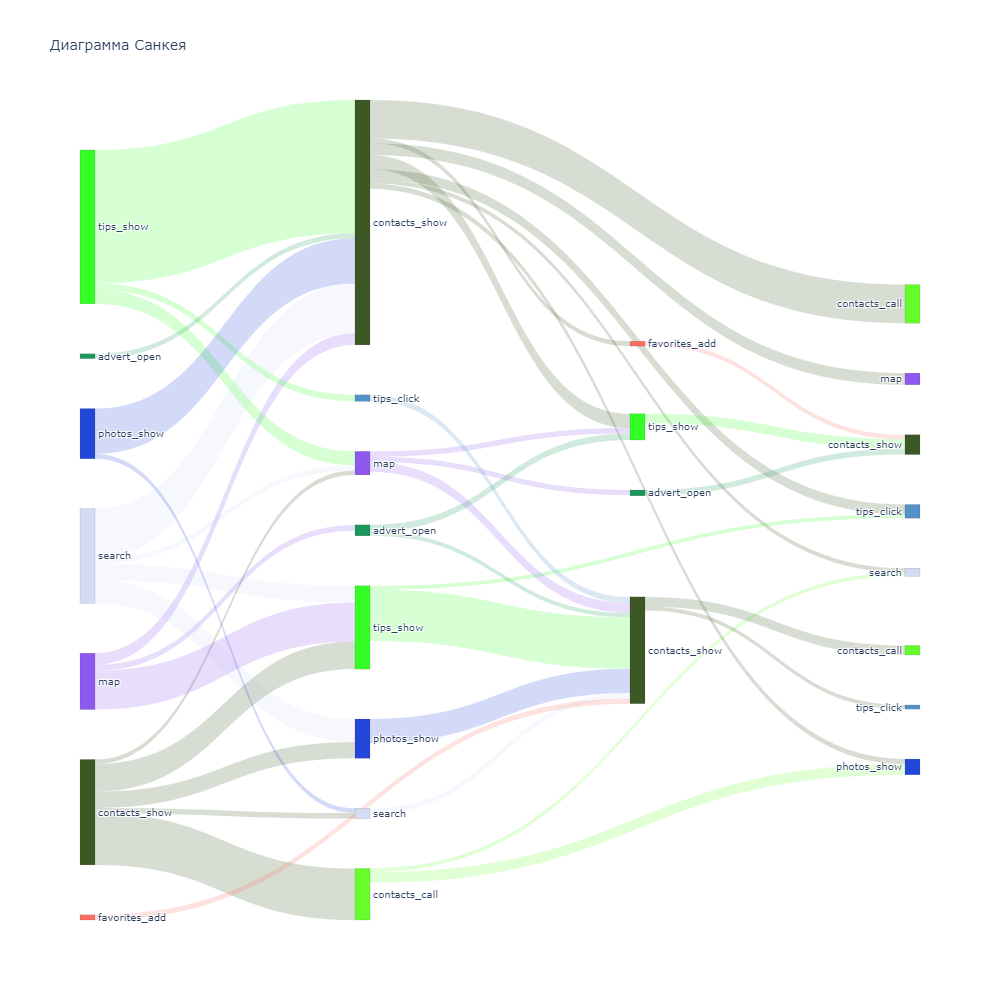

In [124]:
# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

# отображаем диаграмму
senkey_diagram.show("png")

Таким образом выделим несколько основных воронок сценариев, ведущих к целевому событию "просмотр контактов":
- `tips_show -> contacts_show`
- `search -> contacts_show`
- `photos_show -> contacts_show`
- `map -> tips_show -> contacts_show`

При этом есть большое количество сценариев, начинающихся сразу с целевого события `contacts_show`.

#### Построение воронок по основным сценариям

Построим 4 воронки по основным сценариям в контексте уникальных пользователей. Для этого создадим функцию `create_funnel_df`:

In [128]:
def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=0):
    
    # фильтрация необходимых событий
    df = df[['user_id', 'event_name', 'event_time']]
    df = df[df['event_name'].isin(steps)]

    values = [] # для определения количества пользователей на каждом уровне
    title="Событийная воронка " # начало заголовка графика
    
    # фильтрация по каждому событию
    for i, step in enumerate(steps):
        
        # добавляем подписи сценария в заголовок графика
        if i != len(event_names)-1:
            title += str(event_names[i]) + ' -> '
        else: title += str(event_names[i])
            
        if i == 0:
            dfs = {}

            dfs[step] = df[df['event_name'] == step] \
                .sort_values(['user_id', 'event_time'], ascending=True) \
                .drop_duplicates(subset=['user_id', 'event_name'], keep='first')

            # фильтрация первого события в случаях, когда оно произошло между двумя датами
            if from_date:
                dfs[step] = dfs[step][(dfs[step]['event_time'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['event_time'] <= to_date)]
                
        else:
            dfs[step] = df[df['event_name'] == step]

            # соединение с предыдущим шагом
            merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='user_id', how='outer')
            
            # фильтр по уникальным distinct_id
            valid_ids = dfs[steps[i - 1]]['user_id'].unique()
            merged = merged[merged['user_id'].isin(valid_ids)]

            # сохранение только события, произошедшие после предыдущего шага + сортируем по времени
            merged = merged[merged['event_time_y'] >= 
                            (merged['event_time_x'] + timedelta(days=step_interval))].sort_values('event_time_y', ascending=True)

            # сохранение минимального времени выполнения шага для пользователя
            merged = merged.drop_duplicates(subset=['user_id', 'event_name_x', 'event_name_y'], keep='first')

            # оставляем только нужные столбцы
            merged = merged[['user_id', 'event_name_y', 'event_time_y']].rename({'event_name_y': 'event_name',
                                                                         'event_time_y': 'event_time'}, axis=1)

            # включаем df в словарь для последующего объединения с другими шагами
            dfs[step] = merged

        # добавляем количество пользователей
        values.append(len(dfs[step]))

    # создаём датафрейм
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    
    # задаём объект фигуры
    fig = go.Figure(go.Funnel(
        y = funnel_df['step'],
        x = funnel_df['val'],
        textinfo = "value + percent initial + percent previous"))
    fig.update_layout(title=title)
    

    return funnel_df, fig

##### Воронка `tips_show -> contact_show`

Для построения воронки вызовем функцию `funnel_func` с заданным списком событий:

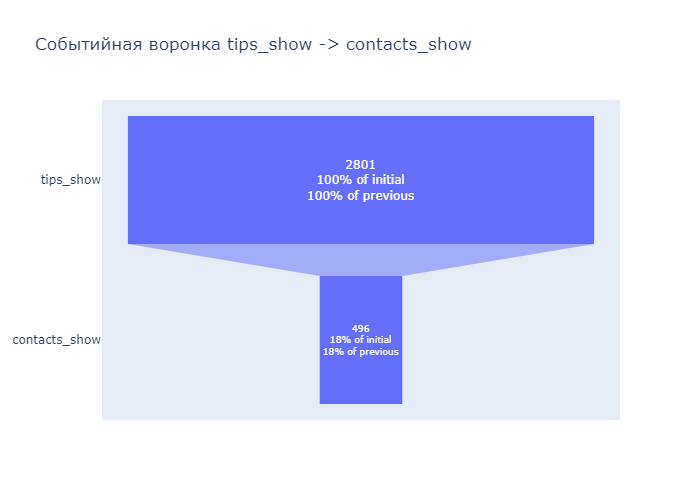

,step,val
0,tips_show,2801
1,contacts_show,496


In [131]:
event_names = ['tips_show', 'contacts_show']
dt, fig = create_funnel_df(dt_merged, event_names)
fig.show("png")
dt

Так, 17,7% пользователей, которые хоть раз видели рекомендованные объявления, также выполняют целевое действие - просмотр контактов.

##### Воронка `search -> contacts_show`

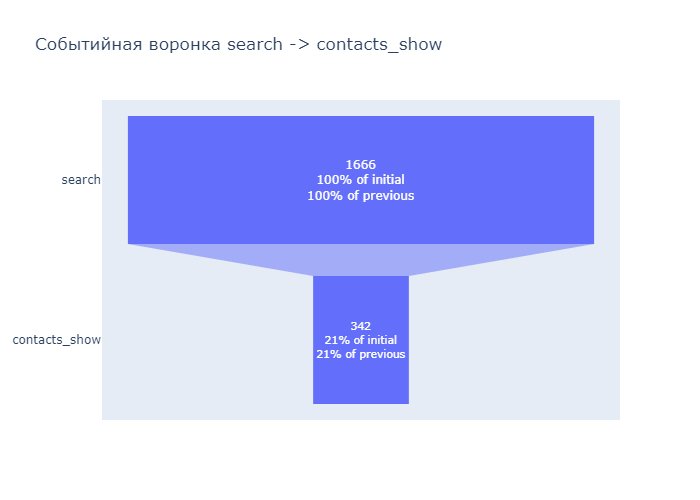

,step,val
0,search,1666
1,contacts_show,342


In [134]:
event_names = ['search', 'contacts_show']
dt, fig = create_funnel_df(dt_merged, event_names)
fig.show("png")
dt

Около 20,5% пользователей, которые хоть раз совершали поиск, также выполняли целевое действие - просмотр контактов.

##### Воронка `photos_show -> contacts_show`

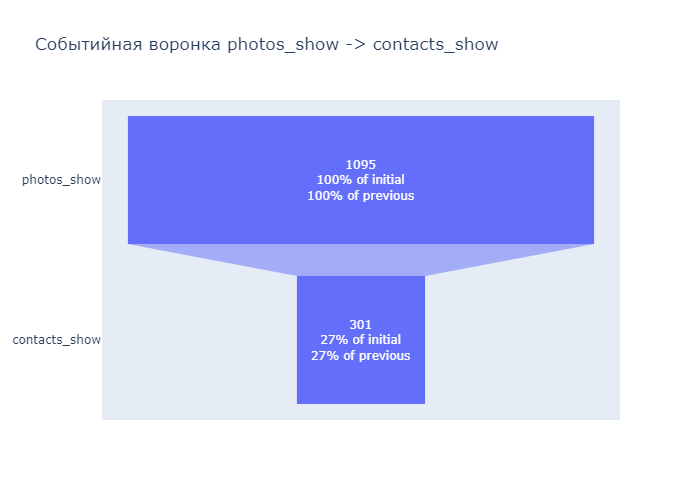

,step,val
0,photos_show,1095
1,contacts_show,301


In [137]:
event_names = ['photos_show', 'contacts_show']
dt, fig = create_funnel_df(dt_merged, event_names)
fig.show("png")
dt

27,5% пользователей, которые просматривают фото, также просматривают контакты.

##### Воронка `map -> tips_show -> contacts_show`

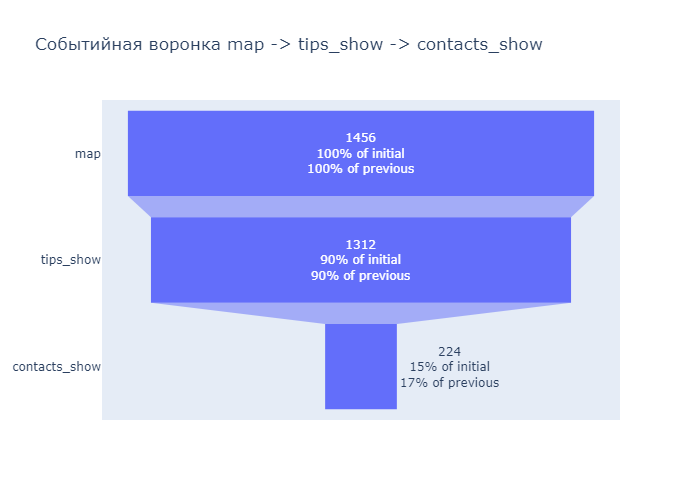

,step,val
0,map,1456
1,tips_show,1312
2,contacts_show,224


In [140]:
event_names = ['map', 'tips_show', 'contacts_show']
dt, fig = create_funnel_df(dt_merged, event_names)
fig.show("png")
dt

Из тех кто просматривает карту и видит рекомендованные объявления 17% также просматривают контакты.

**Вывод**

При анализе связи между целевым событием - *просмотр контактов* - и другими событиями:

- построена диаграмма Санкея отображающая основные потоки между событиями;
- выявлены основные сценарии ведущие к выполнению целевого действия;
- построены воронки событий по выбранным сценариям в разрезе уникальных пользователей, среди которых наибольший относительный процент целевого события выполняют пользователи, которые просматривают фото товара (27,5%).

### Относительная частота событий в разрезе групп пользователей, которые смотрели и не смотрели контакты

Далее проведём оценку, какие действия чаще совершают пользователи, которые просматривают и не просматривают контакты.

In [145]:
# изменим бинарный признак на понятные подписи
dt_merged['target_action'] = dt_merged['target_action'].map({False: 'Не смотрели контакты', True: 'Смотрели контакты'})

# создаем сводную таблицу по событиям и группам пользователей:
event_contacts = dt_merged.groupby(['event_name', 'target_action']).agg(count=('user_id', 'count')).reset_index()

# добавляем сумму кол-ва событий в обеих группах для дальнейшего расчета доли каждого события в разрезе групп
event_contacts['sum'] = event_contacts.groupby('target_action')['count'].transform(sum)

# добавляем данные с долями и сортируем
event_contacts['percent'] = round(event_contacts['count'] / event_contacts['sum']*100, 1)
event_contacts = event_contacts.sort_values(by='percent')

event_contacts

,event_name,target_action,count,sum,percent
12,tips_click,Не смотрели контакты,481,47000,1.0
13,tips_click,Смотрели контакты,333,27197,1.2
5,favorites_add,Смотрели контакты,424,27197,1.6
2,contacts_call,Смотрели контакты,541,27197,2.0
4,favorites_add,Не смотрели контакты,993,47000,2.1
7,map,Смотрели контакты,1101,27197,4.0
1,advert_open,Смотрели контакты,1589,27197,5.8
6,map,Не смотрели контакты,2780,47000,5.9
11,search,Смотрели контакты,2084,27197,7.7
0,advert_open,Не смотрели контакты,4575,47000,9.7


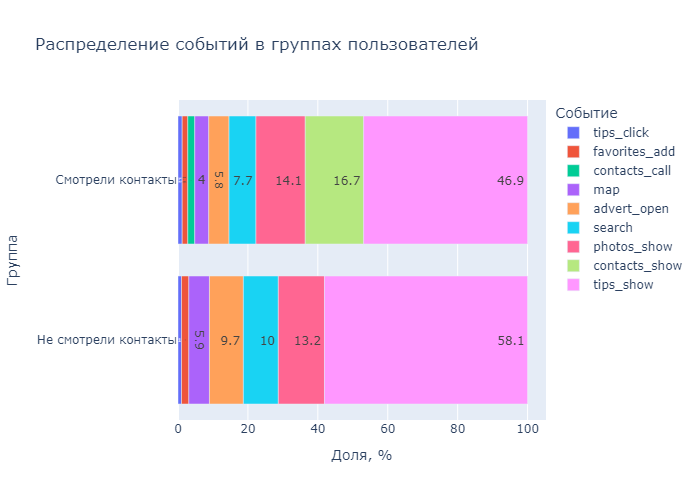

In [251]:
# строим график с разделением на группы

fig = px.bar(event_contacts,
             x='percent',
             y='target_action',
             color='event_name',
             title='Распределение событий в группах пользователей',
             text='percent')

fig.update_layout(
    yaxis_title="Группа",
    xaxis_title="Доля, %",
    legend_title='Событие',
)

fig.show("png")

Таким образом, в обеих группах наиболее популярное событие - `tips_show`. Однако, данное событие отображается автоматически для всех пользователей и не зависит от их действий.

После просмотра контактов у пользователей группы целевого события и второе по популярности у группы пользователей, не смотревших контакты, является событие `photos_show`.
Почти во всех случаях частота событий у группы, не смотревших контакты выше, чем частота событий у пользователей, совершивших действие просмотра контактов (исключение `photos_show` и `tips_click`), это происходит в результате отсутствия у группы, не смотревшей контакты, двух событий. При этом логично, что у группы, не совершавшей целевое действие, нет события `contacts_call`.

### Проверка гипотез

#### Гипотеза 1. Конверсия в просмотры контактов различается у групп пользователей, совершивших действия `tips_show `и `tips_click` , и совершавших только `tips_show`.

Данная гипотеза о равенстве долей двух групп.

Сформулируем двустороннюю гипотезу:

- H0: *конверсия в просмотры контактов группы пользователей, совершивших `tips_show `и `tips_click` = конверсия в просмотры контактов группы пользователей, совершивших только `tips_show `*
- H1: *конверсия в просмотры контактов группы пользователей, совершивших `tips_show `и `tips_click` ≠ конверсия в просмотры контактов группы пользователей, совершивших только `tips_show `*

Создадим функцию `z-test`, которая позволит сравнивать выборки по разным событиям для разных групп:

In [152]:
def z_test(users_event_group1, users_event_group2, users_group1, users_group2, alpha):
    
    # пропорция пользователей, совершивших событие в первой группе:
    p1 = users_event_group1/users_group1
    
    # пропорция пользователей, совершивших событие во второй группе:
    p2 = users_event_group2/users_group2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (users_event_group1 + users_event_group2) / (users_group1 + users_group2)
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_group1 + 1/users_group2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Воспользуемся фнкцией `funnel_func` для нахождения групп пользователей. Для начала необходимо посчитать конверсию в просмотры у каждой группы пользователей, то есть посчитать долю пользователей, совершивших целевое событие.

In [154]:
event_names = ['tips_show', 'tips_click', 'contacts_show']
dt_1, fig = create_funnel_df(dt_merged, event_names)
dt_1

,step,val
0,tips_show,2801
1,tips_click,293
2,contacts_show,67


In [155]:
round(dt_1.loc[len(dt_1)-1,'val']/dt_1.loc[len(dt_1)-2,'val'],2) # users_event_group1/users_group1

0.23

Конверсия в просмотры у группы, совершивших `tips_show` и `tips_click` 23%.

In [157]:
event_names = ['tips_show', 'contacts_show']
dt_2, fig = create_funnel_df(dt_merged, event_names)
dt_2

,step,val
0,tips_show,2801
1,contacts_show,496


Нужно отнять от полученного количества пользователей, тех, кто совершал `tips_click`:

In [159]:
round((dt_2.loc[len(dt_2)-1,'val']-dt_1.loc[len(dt_1)-1,'val'])
    /(dt_2.loc[len(dt_2)-2,'val']-dt_1.loc[len(dt_1)-2,'val']),2) # users_event_group2/users_group2

0.17

Конверсия в просмотры у группы, совершивших `tips_show` и не совершивших `tips_click` 17%.

Далее вызовем функцию `z-test` для двух групп пользователей. Примем исходный уровень значимости равный 5%.

In [162]:
alpha = 0.05 #уровень статистической значимости

In [163]:
z_test(
    dt_1.loc[len(dt_1)-1,'val'],
    dt_2.loc[len(dt_2)-1,'val']-dt_1.loc[len(dt_1)-1,'val'],
    dt_1.loc[len(dt_1)-2,'val'],
    dt_2.loc[len(dt_2)-2,'val']-dt_1.loc[len(dt_1)-2,'val'],
    alpha
)

p-значение:  0.01449778823624115
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод**

Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Значит, есть основания говорить, что конверсии в просмотры у групп пользователей, совершивших действия `tips_show `и `tips_click`, и совершавших только `tips_show` действительно разные.

#### Гипотеза 2. Конверсия в просмотры контактов одинакова у пользователей, совершивших действия `photos_show` и `favorites_add` и у пользователей совершивших только `photos_show`.

Сформулируем нулевую и правостороннюю гипотезу:

- H0: *конверсия в просмотры контактов группы пользователей, совершивших `photos_show `и `favorites_add` = конверсия в просмотры контактов группы пользователей, совершивших только `photos_show `*
- H1: *конверсия в просмотры контактов группы пользователей, совершивших `photos_show `и `favorites_add` ≠ конверсия в просмотры контактов группы пользователей, совершивших только `photos_show `*

Воспользуемся фнкцией `funnel_func` для нахождения групп пользователей. Для начала необходимо посчитать конверсию в просмотры у каждой группы пользователей, то есть посчитать долю пользователей, совершивших целевое событие.

In [168]:
event_names = ['photos_show', 'favorites_add', 'contacts_show']
dt_1, fig = create_funnel_df(dt_merged, event_names)
dt_1

,step,val
0,photos_show,1095
1,favorites_add,167
2,contacts_show,42


In [169]:
round(dt_1.loc[len(dt_1)-1,'val']/dt_1.loc[len(dt_1)-2,'val'],2) # users_event_group1/users_group1

0.25

Конверсия в просмотры у группы, совершивших `photos_show` и `favorites_add` 25%.

In [171]:
event_names = ['photos_show', 'contacts_show']
dt_2, fig = create_funnel_df(dt_merged, event_names)
dt_2

,step,val
0,photos_show,1095
1,contacts_show,301


Нужно отнять от полученного количества пользователей, тех, кто совершал `favorites_add`:

In [173]:
round((dt_2.loc[len(dt_2)-1,'val']-dt_1.loc[len(dt_1)-1,'val'])/
      (dt_2.loc[len(dt_2)-2,'val']-dt_1.loc[len(dt_1)-2,'val']),2) # users_event_group2/users_group2

0.28

Конверсия в просмотры у группы, совершивших `photos_show` и не совершавших `favorites_add` 28%.

Вызовем функцию `z-test` для двух групп пользователей с исходным уровнем значимости 5%.

In [176]:
z_test(
    dt_1.loc[len(dt_1)-1,'val'],
    dt_2.loc[len(dt_2)-1,'val']-dt_1.loc[len(dt_1)-1,'val'],
    dt_1.loc[len(dt_1)-2,'val'],
    dt_2.loc[len(dt_2)-2,'val']-dt_1.loc[len(dt_1)-2,'val'],
    alpha
)

p-значение:  0.46209905431268394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

Полученное значение p-value больше заданного уровня значимости. Значит, есть основания говорить, что конверсия в просмотры контактов одинакова у пользователей, совершивших действия `photos_show` и `favorites_add` и у пользователей совершивших только `photos_show`.

**Вывод**

Полученное значение p-value больше заданного уровня значимости. Значит, есть основания говорить, что конверсия в просмотры контактов одинакова у пользователей, совершивших действия `photos_show` и `favorites_add` и у пользователей совершивших только `photos_show`.

## Общий вывод и рекомендации по результатам исследования<a id='6'></a>

В ходе проведенного исследования для приложения *Ненужные вещи* проанализированы данные о пользователях, привлечённых с 7 октября по 3 ноября 2019 года, их действиях и сессиях.
Исследование проводилось в несколько этапов:

- выполнена предобработка данных: установлен корректный тип данных и стиль оформления, проведена проверка на пропуски и дубликаты;
- проведен исследовательский анализ данных, включающий обработку источников установки приложения и соотношение пользователей по выполнению целевого действия;
- выделены профили пользователей;
- рассчитаны и визуализированы такие метрики, как конверсия и удержание пользователей;
- проанализирована связь целевого события - просмотра контактов - с другими событиями: построена диаграмма Санкея и воронки по основным сценариям, ведущим к целевому событию;
- рассмотрена относительная частота событий в разрезе групп пользователей, которые смотрели и не смотрели контакты;
- проверены две статистические гипотезы.

**Ниже приведены выводы по каждому шагу исследования:**

**В ходе исследовательского анализа данных, получены следующие результаты:**

1. Чаще всего пользователи устанавливают приложение через *yandex* - в 45% случаев, реже всего - через *google* - в 26% случаев. При этом целевое действие выполняют большинство пользователей пришедших из yandex, реже - пришедшие из google. Это означает, что зависимости между источниками установки и выполнением целевого действия нет.


2. Большинство пользователей ни разу не просматривали контакты покупателей - около 77%. Скорее всего, они не находят в приложении того, что искали, либо осуществляют только продажу товаров и их не интересует покупка.


3. Пользователи приложения на 14-й день конвертируются с показателем ~ 22,5%. Конверсия 14-го дня волатильная, это может быть связано с небольшим количеством наблюдений, которые сильно влияют на результат.


4. Удержание пользователей, просматривающих контакты выше, чем непросматривавших, удержание в обеих группах пользователей постепенно снижается. Есть резкий скачок удержания на 7 день среди пользователей, выполняющих целевое действие, на это может влиять необходимость обновления объявления через неделю после размещения, что может привлекать пользователей для повторного возвращения в приложение и просмотра интересных объявлений. При этом динамика удержания пользователей на 14-й день падает в отношении пользователей привлеченных с конца октября.


5. Выделены несколько основных воронок сценариев, ведущих к целевому событию "просмотр контактов":

- `tips_show -> contacts_show`
- `search -> contacts_show`
- `photos_show -> contacts_show`
- `map -> tips_show -> contacts_show`

    Есть большое количество сценариев, начинающихся сразу с целевого события `contacts_show`.
    
6. При построении воронок по выбранным сценариям в разрезе уникальных пользователей наибольший относительный процент целевого события выполняют пользователи, которые просматривают фото товара (27,5%).


7. Наиболее популярное событие среди пользователей, как просматривавших так и не просматривавших контакты, - `tips_show`.  Однако, данное событие отображается автоматически для всех пользователей и не зависит от их действий. Почти во всех случаях частота событий у группы, не смотревших контакты выше, чем частота событий у пользователей, совершивших действие просмотра контактов (исключение `photos_show` и `tips_click`), это происходит в результате отсутствия у группы, не смотревшей контакты, двух событий.

**Были проверены следущие гипотезы:**

1. В результате проверки гипотезы о том, конверсия в просмотры контактов различается у групп пользователей, совершивших действия `tips_show` и `tips_click`, и совершавших только `tips_show`, статистический тест показал, что *есть основания говорить, что конверсии в просмотры у данных групп пользователей разные*.


2. Проверка гипотезы о том, что конверсии в просмотры контактов у пользователей, совершивших действия `photos_show` и `favorites_add` и у пользователей совершивших только `photos_show` одинаковы, показала, что *есть основания говорить, что конверсия в просмотры контактов у данных групп пользователей действительно одинаковы*.

**Дальнейшие рекомендации для увеличения вовлеченности пользователей:** 

1. Стоит обратить внимание на то, что динамика удержания пользователей на 14-й день начала падать в отношении пользователей привлеченных в конце октября, необходимы мероприятия по удержанию пользователей;


2. Чаще остальных пользователи, просматривающие фотографии товара, выполняют целевое действие по просмотру контактов. Важно стимулировать продавцов загружать, как можно больше фото своего товара, так как это влияет на принятие решений о покупке. Можно зафиксировать минимальное количество фотографий, которые должен загружать продавец;


3. Пользователи, которые не просматривают контакты, почти в 2 раза чаще открывают карту, чем те, кто просматривают контакты. Возможно, многим таким пользователям недоступна покупка товара из-за местоположения. Стоит рассмотреть способы доставки товара с условиями, которые повысят вовлеченность пользователей;


4. Конверсия пользователей, которые просматривают и открывают рекомендованные объявления выше, чем конверсия тех, кто только видит рекомендованные объявления. Стоит сделать акцент на развитие рекомендательной системы приложения, чтобы показывать пользователям именно то, что их заинтересует и, тем самым, повысить конверсию в целевое действие.